In [45]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

In [46]:

data_dir = 'data_log'
subj = 'R2210'
data_log_dir = f"{data_dir}/{subj}"
json_files = glob.glob(os.path.join(data_log_dir, '*.json'))

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each JSON file and read it into a DataFrame
for json_file in json_files:
    try:
        with open(json_file, 'r') as file:
            data = json.load(file)
            trial_data = data['trial_data']
            # loc_data = data['locolizer_data']
        df = pd.json_normalize(trial_data)
        dataframes.append(df)
    except json.JSONDecodeError as e:
        print(f"Error reading file {json_file}: {e}")
if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
else:
    print("No valid JSON files found.")

In [47]:
# Function to calculate total time for each trial
def calculate_total_time(events):
    start_time = None
    done_time = None
    timeout = False
    for event in events:
        if event['event'] == 'start':
            start_time = event['time']

        elif event['event'] == 'done':
            done_time = event['time']
            break  # Stop once we find the 'done' event
        elif event['event'] == 'timeout':
            done_time = event['time']
            timeout = True
            break  # Stop once we find the 'dßone' event
    
    if start_time is not None and done_time is not None:
        return done_time - start_time, timeout 
    else:
        return None  # Return None if either start or done time is missing

def calculate_reveal(events):
    num_reveal = 1
    reveal_array = []
    num_white = 0
    num_red =1 
    for event in events:
        if event['event'] == 'reveal_white':
            num_white += 1
            num_reveal += 1
        elif event['event'] == 'reveal_red':
            num_red += 1
            num_reveal += 1
    return num_white, num_red, num_reveal

def reveal_interval(events):
    reveal_interval = []
    for event in events:
        if event['event'] == 'reveal_white':
            reveal_interval.append(event['time'])
        elif event['event'] == 'reveal_red':
            reveal_interval.append(event['time'])
    return reveal_interval

combined_data['num_white'], combined_data['num_red'], combined_data['num_reveal'] = zip(*combined_data['events'].apply(calculate_reveal))
combined_data['total_t'], combined_data['timeout'] = zip(*combined_data['events'].apply(calculate_total_time))


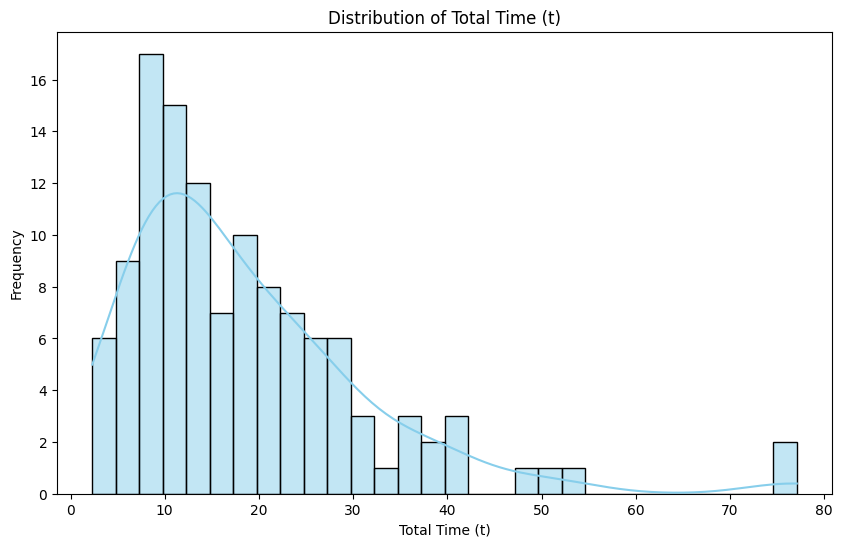

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values from 'total_t' for plotting
total_t_values = combined_data['total_t'].dropna()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(total_t_values, bins=30, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Total Time (t)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Time (t)')

# Show the plot
plt.show()

In [49]:
combined_data['timeout'].value_counts()


timeout
False    120
Name: count, dtype: int64

In [50]:
# combined_data['trial.start'] = combined_data['trial.start'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)



In [51]:
label_df = combined_data[['trial.rule']].copy()
label_df['start_loc'] = combined_data['trial.start']
label_df['trial_index'] = combined_data.index
label_df['t'] = combined_data['total_t']
label_df['timeout'] = combined_data['timeout']
label_df.to_csv(f'{data_dir}/{subj}/label.csv')
print(label_df)

    trial.rule start_loc  trial_index          t  timeout
0         tree    [5, 2]            0  26.324863    False
1        chain    [2, 3]            1  35.953921    False
2         tree    [4, 4]            2  17.472037    False
3         loop    [4, 5]            3  53.221225    False
4        chain    [2, 4]            4  19.869792    False
..         ...       ...          ...        ...      ...
115       tree    [2, 4]          115  17.525416    False
116       loop    [5, 3]          116  17.548273    False
117       tree    [5, 4]          117  27.552800    False
118       loop    [5, 3]          118  10.450613    False
119      chain    [2, 5]          119   7.440448    False

[120 rows x 5 columns]
